# Figure 3
 - Explained variance each subject individually
 

In [1]:
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from subjects import sd,nsd,sd_colors,figpath_sd
from neuropy.analyses import ExplainedVariance
from neuropy import plotting

sd_sessions = sd.ratNday1 + sd.ratSday3  + sd.ratUday4
nsd_sessions = nsd.ratNday2 + nsd.ratSday2 + nsd.ratUday2

In [2]:
sd_expvar, nsd_expvar = [], []
for grp, sessions in enumerate([sd_sessions, nsd_sessions]):
    for sub, sess in enumerate(sessions):
        pre = sess.paradigm["pre"]
        maze = sess.paradigm["maze"]
        if maze.size ==0:
            maze = sess.paradigm["maze1"]
        post = sess.paradigm["post"]

        re_maze = sess.paradigm['re-maze']
        if re_maze.size !=0:
            post = [post[0],re_maze[1]]

        neurons = sess.neurons.get_neuron_type("pyr")
        expvar = ExplainedVariance(
            neurons=neurons, template=maze, matching=post, control=pre
        )
        if grp == 0:
            sd_expvar.append(expvar)
        else:
            nsd_expvar.append(expvar)


/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


## Plotting

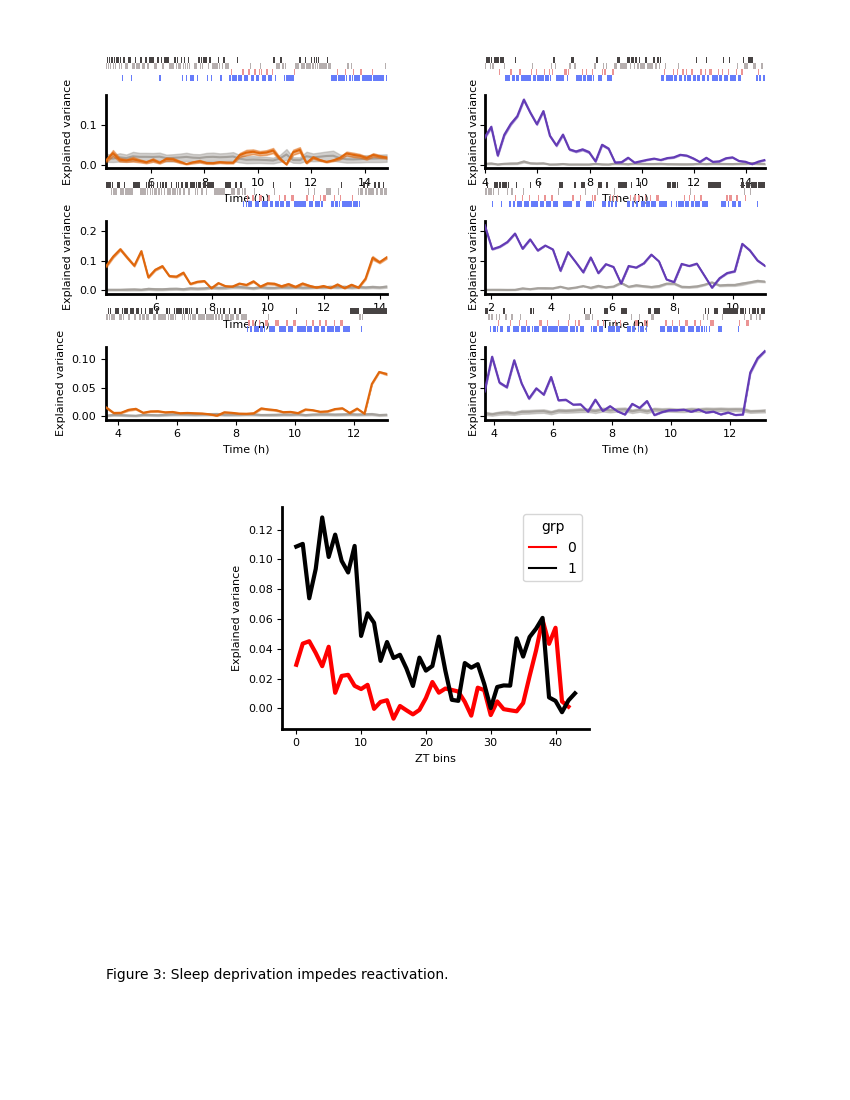

In [4]:
%matplotlib widget
import seaborn as sns
import numpy as np

figure = plotting.Fig()
fig, gs = figure.draw(num=1, grid=(7, 4), hspace=0.3, wspace=0.35)
fig.suptitle("Figure 3", x=0, ha="left", fontsize=16)

# ------- plotting individual sessions ---------
subfig = fig.add_subfigure(gs[:3, :])
axs_subfig = subfig.subplots(
    6, 2, sharex=False, sharey="row", gridspec_kw={"height_ratios": [1, 3, 1, 3, 1, 3]}
)
sessions = [sd_sessions, nsd_sessions]
for grp_i, (expvar_grp, grp) in enumerate(zip([sd_expvar, nsd_expvar], ["sd", "nsd"])):
    grp_sessions = sessions[grp_i]
    for i, expvar in enumerate(expvar_grp):
        ax = axs_subfig[2 * i + 1, grp_i]
        expvar.colors["ev"] = sd_colors[grp]
        expvar.colors["rev"] = "#a5a19c"
        expvar.plot(ax=ax, legend=None)

        post = grp_sessions[i].paradigm["post"]
        rec_stop = grp_sessions[i].eegfile.duration
        post_brainstates = grp_sessions[i].brainstates.time_slice(post[0], rec_stop)
        ax_hypno = axs_subfig[2 * i, grp_i]
        plotting.plot_hypnogram(post_brainstates, ax=ax_hypno)

df = pd.DataFrame()
for grp, expvars in enumerate([sd_expvar, nsd_expvar]):
    for i, expvar in enumerate(expvars):
        ev_diff = expvar.ev - expvar.rev
        ev_bins = np.arange(len(ev_diff))
        df = df.append(
            pd.DataFrame({"ev_diff": ev_diff, "bins": ev_bins, "grp": grp}),
            ignore_index=True,
        )

ax = plt.subplot(gs[3:5, 1:3])
sns.lineplot(
    data=df,
    x="bins",
    y="ev_diff",
    hue="grp",
    ci=None,
    ax=ax,
    linewidth=3,
    palette=["r", "k"],
)
ax.set_ylabel("Explained variance")
ax.set_xlabel("ZT bins")

# ----- caption --------
ax_caption = figure.add_subplot(gs[6:, :])
ax_caption.text(
    0,
    0,
    "Figure 3: Sleep deprivation impedes reactivation.",
    wrap=True,
)
ax_caption.axis("off")
figure.savefig(figpath_sd / "figure3")
